In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing as process
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import statistics
from sklearn.naive_bayes import GaussianNB

In [2]:
data = pd.read_csv("./Train_B.csv")
data = data.drop(['case_id'], axis=1)
data.isnull().sum()

Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [3]:
data.columns

Index(['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')

In [4]:
for col in data.columns:
    print(col + "   " + str(len(data[col].unique())))

Hospital_code   32
Hospital_type_code   7
City_Code_Hospital   11
Hospital_region_code   3
Available Extra Rooms in Hospital   18
Department   5
Ward_Type   6
Ward_Facility_Code   6
Bed Grade   5
patientid   92017
City_Code_Patient   38
Type of Admission   3
Severity of Illness   3
Visitors with Patient   28
Age   10
Admission_Deposit   7300
Stay   11


In [5]:
data['Bed Grade'] = data['Bed Grade'].fillna(data['Bed Grade'].mode()[0])
data['City_Code_Patient'] = data['City_Code_Patient'].fillna(data['City_Code_Patient'].mode()[0])

In [6]:
decoder_list = {}
for x in data.columns:
    le = process.LabelEncoder()
    data[x] = le.fit_transform(data[x])
    decoder_list[x] = le;

data.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,7,2,2,2,3,3,2,5,1,21972,6,0,0,2,5,2954,0
1,1,2,4,2,2,3,3,5,1,21972,6,1,0,2,5,3997,4
2,9,4,0,0,2,1,3,4,1,21972,6,1,0,2,5,2788,3
3,25,1,1,1,2,3,2,3,1,21972,6,1,0,2,5,5315,4
4,25,1,1,1,2,3,3,3,1,21972,6,1,0,2,5,3601,4


In [7]:
Y = data['Stay']
X = data.drop(['Stay'],axis=1)

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state = 42)
X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

In [9]:
def fit_naive_bayes(X_train,Y_train):
    lookup_table = {}
    for x in X_train.columns:
        rows = X_train[x].max()+1
        cols = Y_train.max()+1
        lookup_table[x] = [[1 for p in range(cols)] for q in range(rows)]
        for i in range(X_train.shape[0]):
            lookup_table[x][int(X_train[x][i])][int(Y_train[i])] += 1
    return lookup_table

In [10]:
def get_y_probablity(Y_train):
    probaby = [1 for i in range(Y_train.max()+1)]
    for x in Y_train:
        probaby[int(x)] += 1 
    return probaby
    

In [11]:
def predict(X_test,Y_train,lookup_table,probaby):
    foobar = []
    for i in range(X_test.shape[0]):
        examp = X_test.iloc[i]
        mx = float('-inf')
        ans = 100
        for classes in range(Y_train.max()+1):
            prod = 0
            for col in X_test.columns:
                temp = 1
                if int(examp[col])>=len(lookup_table[col]) or classes>=len(lookup_table[col][int(examp[col])]):
                    temp = 1
                else:
                    temp = lookup_table[col][int(examp[col])][int(classes)]
                prod += math.log(temp) 

            prod += math.log(probaby[int(classes)])

            if prod>mx:
                mx = prod
                ans = classes

        foobar.append(ans)
    return foobar

In [12]:
def get_acc(Y_test,Y_pred):
    acc = 0
    for i in range (Y_test.shape[0]):
        if Y_pred[i]==Y_test[i]:
            acc+=1
    return acc/len(Y_test)

In [13]:
def testing(X_train,Y_train,X_test,Y_test):
    lookup = fit_naive_bayes(X_train,Y_train)
    probaby = get_y_probablity(Y_train)
    y_predict = predict(X_test,Y_train,lookup,probaby)
    ans = get_acc(Y_test,y_predict)
    return ans

In [100]:
testing(X_train,Y_train,X_test,Y_test)

0.2975756814470544

In [14]:
def KFoldCrossValidation(X,Y,k=5):
    n = int(X.shape[0]//k)
    for i in range(k):
        cv_indices = list(range(i*n,min((i+1)*n , X.shape[0])))
        X_test1 = X.loc[cv_indices]
        Y_test1 = Y.loc[cv_indices]
        X_train1 = X.drop(cv_indices)
        Y_train1 = Y.drop(cv_indices)
        
        X_train1 = X_train1.reset_index(drop=True)
        Y_train1 = Y_train1.reset_index(drop=True)
        X_test1 = X_test1.reset_index(drop=True)
        Y_test1 = Y_test1.reset_index(drop=True)
        
        ans = testing(X_train1,Y_train1,X_test1,Y_test1)
        
        print(ans)
        

In [194]:
KFoldCrossValidation(X_train,Y_train)

0.29695780176643766
0.2929342492639843
0.29328753680078506
0.29501472031403336
0.2911874386653582


# Part Two Starts

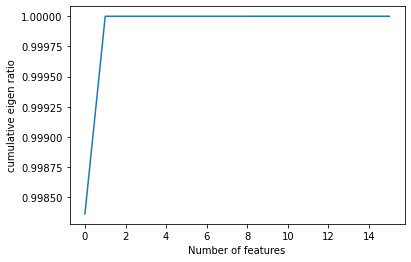

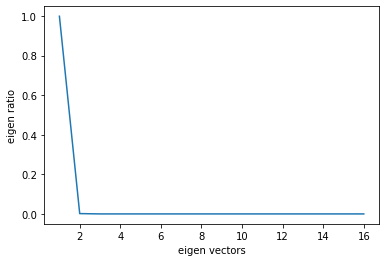

In [22]:
pca = PCA(n_components=len(X.columns))
pca.fit(X)
variances = pca.explained_variance_ratio_
total = 0
num_of_components = 0
while total<0.95:
    total += variances[num_of_components]
    num_of_components+=1
eigen_vectors = pca.components_[0:num_of_components]

new_x = np.matmul(X.to_numpy() , np.transpose(eigen_vectors))
new_X = {}
for i in range(len(new_x[0])):
    temp = "Col"+str(i)
    new_X[temp] = new_x[: , i]
    
PCA_X = pd.DataFrame(new_X)
x_axis = []

graph_variances = [0 for i in range(len(variances))]
for i in range(len(variances)):
    if i>0:
        graph_variances[i] = graph_variances[i-1]+variances[i]
    else:
        graph_variances[i] = variances[i]
    x_axis.append(i+1)
plt.plot(graph_variances)
plt.ylabel("cumulative eigen ratio")
plt.xlabel("Number of features")
plt.show()

plt.plot(x_axis,variances)
plt.ylabel("eigen ratio")
plt.xlabel("eigen vectors")
plt.show()


In [15]:

new_decoder_list = {}
for x in PCA_X.columns:
    new_le = process.LabelEncoder()
    PCA_X[x] = new_le.fit_transform(PCA_X[x])
    new_decoder_list[x] = new_le;
    
PCA_X_train,PCA_X_test,PCA_Y_train,PCA_Y_test = train_test_split(PCA_X,Y,test_size = 0.2,random_state = 42)
PCA_X_train = PCA_X_train.reset_index(drop=True)
PCA_Y_train = PCA_Y_train.reset_index(drop=True)
PCA_X_test = PCA_X_test.reset_index(drop=True)
PCA_Y_test = PCA_Y_test.reset_index(drop=True)


In [197]:
KFoldCrossValidation(PCA_X_train,PCA_Y_train)

0.27636898920510305
0.2745829244357213
0.2740529931305201
0.2746221786064769
0.2722080471050049


In [198]:
lookup = fit_naive_bayes(PCA_X_train,PCA_Y_train)
probaby = get_y_probablity(PCA_Y_train)
y_predict = predict(PCA_X_test,PCA_Y_train,lookup,probaby)
get_acc(PCA_Y_test,y_predict)

0.2764728049240045

# Part Three Starts

In [40]:
feature_mean = {}
feature_std = {}
del_ele = set()
mapping = [0 for i in range(X.shape[0])]

for x in X.columns:
    feature_mean[x] = X[x].mean()
    feature_std[x] = X[x].std()
    
for i in range(X.shape[0]):
    for j in X.columns:
        if X[j][i]>feature_mean[j]+3*feature_std[j]:
                mapping[i]+=1
            
mx = max(mapping)
for i in range(X.shape[0]):
    if mapping[i] == mx:
        del_ele.add(i)
            
X = X.drop(index = del_ele)
Y = Y.drop(index = del_ele)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state = 42)
X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)
len(del_ele)

11

In [41]:
def check_backward(X_train,Y_train,X_val,Y_val,feature = None):
    
    X_func_train = X_train
    X_func_val = X_val
    
    if feature!=None:
        X_func_train = X_train.drop([feature],axis=1)
        X_func_val = X_val.drop([feature],axis=1)
    
    clf = DecisionTreeClassifier(random_state = 0)
    clf.fit(X_func_train,Y_train)
    y_pred = clf.predict(X_func_val)
    return get_acc(Y_val,y_pred)
    

In [42]:
X_new_train,X_new_test,Y_new_train,Y_new_test = train_test_split(X_train,Y_train,test_size = 0.2,random_state = 42)
X_new_train = X_new_train.reset_index(drop=True)
Y_new_train = Y_new_train.reset_index(drop=True)
X_new_test = X_new_test.reset_index(drop=True)
Y_new_test = Y_new_test.reset_index(drop=True)

clf = DecisionTreeClassifier(random_state = 0)
clf.fit(X_new_train,Y_new_train)
y_pred = clf.predict(X_new_test)
full_acc = get_acc(Y_new_test,y_pred)

del_feature = []

def backward_selection(X_new_train,Y_new_train,X_new_test,Y_new_test,full_acc):
    max_acc = 0
    max_feature = None
    for x in X_new_train.columns:
        new_acc = check_backward(X_new_train,Y_new_train,X_new_test,Y_new_test,x)

        if new_acc>max_acc:
            max_acc = new_acc
            max_feature = x
 
    if max_acc>full_acc:
        X_new_train = X_new_train.drop([max_feature],axis=1)
        X_new_test = X_new_test.drop([max_feature],axis=1)
        del_feature.append(max_feature)
        full_acc = max_acc
        backward_selection(X_new_train,Y_new_train,X_new_test,Y_new_test,full_acc)


In [43]:
backward_selection(X_new_train,Y_new_train,X_new_test,Y_new_test,full_acc)
X_backward_train = X_train.drop(del_feature,axis=1)
X_backward_test = X_test.drop(del_feature,axis=1)

X_backward_train.columns

Index(['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'Visitors with Patient'],
      dtype='object')

In [44]:
lookup = fit_naive_bayes(X_backward_train,Y_train)
probaby = get_y_probablity(Y_train)
y_predict = predict(X_backward_test,Y_train,lookup,probaby)
get_acc(Y_test,y_predict)

0.2932669660521936

In [45]:
KFoldCrossValidation(X_backward_train,Y_train)

0.29404490853419174
0.2941823035251629
0.2893145952736123
0.2932205385883646
0.2912381251472089
